In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
import pickle
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath(".").split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
from typing import List, Union, Any, Tuple
from datetime import datetime
from random import sample


import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch_geometric
from torch_geometric.data import Data
from torch.nn import BCELoss, LeakyReLU, ReLU
from torch.optim import lr_scheduler, Adagrad, Adadelta, Adam, AdamW

from rdkit import Chem, RDLogger
from rdkit.Chem import (
    Draw,
    AllChem,
    PandasTools,
    MolFromSequence,
    MolToSmiles,
    MolFromSmiles,
    MolToInchiKey,
    Descriptors,
    GraphDescriptors,
    Crippen,
)
from rdkit.Chem import rdMolDescriptors as rdmdesc

from joblib import Parallel, delayed

RDLogger.DisableLog("rdApp.*")
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from lib import (
    gnn_utils,
    utilities,
    datasets,
    splitters,
    featurizers,
    training_utils,
    graph_nns,
    graph_utils,
    visuals,
)


from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import display, HTML

In [4]:
seed = 23332
utilities.set_seeds(seed=seed, torch_use_deterministic_algos=False)

In [5]:
print(featurizers.DF_FUNC_GRPS_MINI.shape)
featurizers.DF_FUNC_GRPS_MINI.head(3)

(154, 2)


,name,SMARTS
0,aldehyde,"[$([CX3H][#6]),$([CX3H2])]=[OX1]"
1,carbonyl,"[$([CX3]=[OX1]),$([CX3+]-[OX1-])]"
2,ketone,[#6][CX3](=[OX1])[#6]


<p style="font-family: cursive; font-size=14px">
In the following, we will train graph convolutional neural networks (GCN) models to predict whether a compound inhibits of the <em>P. falciparum's</em> DD2 growth.This task is a binary classification.
</p>

## Notes of Graph Convolutional Networks
<span style="font-family: cursive; font-size=14px">
<b>Graph Convolutional Networks (GCNs)</b> are a subclass of Graph Neural Networks (GNNs) that apply convolutions to the graph to produce a message, aggregating all neighbors of each node <em>v</em>, including the node itself and aggregating all information. The information. The graph convolution is generally followed by a pooling and/or readout, depending on the intended task (<a href="https://arxiv.org/pdf/1901.00596.pdf">Wu <em>et al.</em> 2019</a>). 
<ul>
<li>The pooling operation aims to reduce the size of parameters by down-sampling the nodes to generate smaller representations and thus avoid overfitting, permutation invariance, and computational complexity issues. A common way to transform each node's information to keep the range of different nodes comparable is through division by the node's degree, since nodes can have different number of neighbors. The authors of the GCN (Kipf et al. in 2016)  noticed that features from nodes with a lot of neighbors will spread much more easily than those from more isolated nodes. To counterbalance this effect, they proposed to give bigger weights to features from nodes with few neighbors.</li>
<li>The readout operation is mainly used to generate a graph-level representation based on node representations.</li>
</ul>
<br/>
<div class="image-title" style="text-align: center;">
    <img src="../../data/figures/gcn.png" width="850" height="400" alt="Wu et al.(2019)">
    <p style="font-size: 12px;">Wu <em>et al.</em>(2019)</p>
</div>
<br> CGNs provides several advantages, including:
<ol>
<li><b>Local Information Aggregation:</b> GCNs effectively capture local graph structure by aggregating information from neighboring nodes. This allows them to model node relationships within the immediate vicinity.</li>
<li><b>Parameter Sharing:</b>The graph convolution operation involves parameter sharing, meaning that the same set of weights is applied to all nodes in the graph. This sharing of parameters helps the model generalize well to different parts of the graph.</li>
</ol>

<br/>GCNs can suffer some limitations, regarding:
<ol>
<li><b>Depth and Over-Smoothing:</b> Deep GCNs may suffer from over-smoothing, where the representations of nodes become too similar after several layers, especially in the presence of large graphs.</li>
<li><b>Handling Graphs with Different Sizes:</b> GCNs assume a fixed-size neighborhood for each node. Handling graphs with varying sizes or irregular structures can be challenging, as the fixed-size aggregation may not capture the full extent of node relationships.</li>
<li><b>Sensitivity to Graph Perturbations:</b> This sensitivity may limit their robustness to noise or changes in the graph topology.</li>
<li><b>Lack of Edge Information:</b> For tasks that heavily rely on edge features, other GNN architectures like GraphSAGE or GAT may be more suitable.</li>
<li><b>Difficulty with Unattributed Graphs: </b> GCNs assume node features as input. For graphs without node features (unattributed graphs), they may not perform as well, and alternative architectures like Graph Isomorphism Networks (GIN) or GraphSAGE might be considered.</li>
</ol>
Moreover, mean-based aggregation, which is not injective. This means that different graphs can have the same embedding and thus, be undistinguisheable. Examples of GNNs thatt have been proposed to overcome the limitations of GCNs include Graph Isomorphism Neetworks (GINs), Graph Attention Networks (GATs), etc.

<br/>Good resources for learning abour GNNs inlcude:
<ol>
<li><a href="https://distill.pub/2021/understanding-gnns/">Understanding Convolutions on Graphs</a>
<li><a href="https://towardsdatascience.com/graph-neural-networks-part-1-graph-convolutional-networks-explained-9c6aaa8a406e">Graph Neural Networks Part 1. Graph Convolutional Networks Explained</a>
<li> <a href="https://github.com/chaitjo/geometric-gnn-dojo/tree/main">geometric-gnn-dojo</a>. Check the geometric_gnn_101.ipynb</li>
<li><a href="https://github.com/qbxlvnf11/graph-neural-networks-for-graph-classification">graph-neural-networks-for-graph-classification</a>
</ol>
</span>

<h3 style="font-family: cursive">Data Preparation</h4>

<h4 style="font-family: cursive">Dataset Cleaning</h4>
<p style="font-family: cursive; font-size=14px">
The dataset was obtained from the PubChem Biossay AID 2302. It was used as example in the paper by [Chakravarti and Mani Alla (2019); Frontiers in Artificial Intelligence, 2, DOI: 10.3389/frai.2019.00017](https://www.frontiersin.org/articles/10.3389/frai.2019.00017/full). </p>


In [6]:
dd2_data_df = pd.read_csv(
    f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302.csv"
)  # .sample(n=500)
smiles_column = "PUBCHEM_EXT_DATASOURCE_SMILES"
# target_column = "PCT_INHIB_DD2"
target_column = "DD2_ACTIVITY_CLS"
mol_column = "RMol"

print(
    f"Number of molecules with a missing SMILES string: {dd2_data_df[smiles_column].isna().sum()}/{dd2_data_df.shape[0]}"
)

# Removing rows with a missing SMILES string
dd2_data_df.dropna(subset=[smiles_column], axis=0, inplace=True)


# Remove rows where is not defined
dd2_data_df.dropna(subset=["PUBCHEM_ACTIVITY_OUTCOME"], axis=0, inplace=True)

# Add a column with 0/1 activity values
dd2_data_df[target_column] = dd2_data_df["PUBCHEM_ACTIVITY_OUTCOME"].apply(
    lambda x: 1 if x == "Active" else 0
)


# Adding molecule (Mol) objects to the dataframe
PandasTools.AddMoleculeColumnToFrame(dd2_data_df, smiles_column, mol_column)

dd2_data_df.head(2)

Number of molecules with a missing SMILES string: 13/13533


,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PCT_INHIB_DD2,DD2_ACTIVITY_CLS,RMol
0,85857918,11957475.0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive,4.0,0,<rdkit.Chem.rdchem.Mol object at 0x7f028a4d3c80>
1,85857919,6618861.0,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active,80.0,1,<rdkit.Chem.rdchem.Mol object at 0x7f028a4d3d60>


<span style="font-family: cursive; font-size=16px">
Beside removing rows with an empty SMILES, we will proceed with the following steps:
<ol>
    <li>Select the largest fragment for each molecule, which will also remove slats, among others. We will use the SMILES and inchikeys of the fragment.</li>
    <li>Sanitize the retained molecule</li>
    <li>Fix the target values. Negative values are set to 0 and values greater than 100 are set to 100</li>
    <li>Remove duplicates, using the inchikey as primary key. For each group of duplicates: </li>
        <ol>
            <li>If the min and max values are apart by 20 or more, omit and proceed to the next group</li>
            <li>Else, retain the first occurrence but replace the target value by an average</li>
            <li>It is worth mentioning that duplicate removal is usually a more involved process, where outliers can be detected and removed using a statisical approach, before averaging the taarget value.</li>
        </ol>
</ol>
</span>

In [7]:
dd2_data_df["largest_frag"] = dd2_data_df[mol_column].apply(
    utilities.get_largest_fragment_from_mol
)

dd2_data_df["largest_frag_smiles"] = dd2_data_df["largest_frag"].apply(
    lambda mol: MolToSmiles(utilities.sanitize_molecule(mol, add_explicit_h=True))
)

dd2_data_df.dropna(subset=["largest_frag_smiles"], axis=0, inplace=True)


dd2_data_df["largest_frag_ikey"] = dd2_data_df["largest_frag"].apply(MolToInchiKey)
duplicates = dd2_data_df[
    dd2_data_df.duplicated(subset=["largest_frag_ikey"], keep=False)
].sort_values(by="largest_frag_ikey")

print(
    f"Number of molecules with a missing largest fragment SMILES string: {dd2_data_df['largest_frag_smiles'].isna().sum()}/{dd2_data_df.shape[0]}"
)

print(
    f"Number of unique inchikeys: {dd2_data_df['largest_frag_ikey'].unique().size}/{dd2_data_df.shape[0]}"
)
print(
    f"Number of duplicates inchikeys: {duplicates.shape[0]} - e.g.: {duplicates.index[:2]}"
)
print(
    f"Number of molecules with a negative target value: {dd2_data_df[dd2_data_df[target_column]<0].shape[0]}/{dd2_data_df.shape[0]} - e.g.:{dd2_data_df[dd2_data_df[target_column]<0].index[:2]}"
)
print(
    f"Number of molecules with target value>100: {dd2_data_df[dd2_data_df[target_column]>100].shape[0]}/{dd2_data_df.shape[0]} - e.g.:{dd2_data_df[dd2_data_df[target_column]>100].index[:2]}"
)
dd2_data_df[["PUBCHEM_CID", "largest_frag_ikey", target_column]].loc[
    [8, 9, 272, 458, 11041, 11042], :
]

Number of molecules with a missing largest fragment SMILES string: 0/13520
Number of unique inchikeys: 13451/13520
Number of duplicates inchikeys: 136 - e.g.: Index([11041, 11042], dtype='int64')
Number of molecules with a negative target value: 0/13520 - e.g.:Index([], dtype='int64')
Number of molecules with target value>100: 0/13520 - e.g.:Index([], dtype='int64')


,PUBCHEM_CID,largest_frag_ikey,DD2_ACTIVITY_CLS
8,13698519.0,QWWAYKRVWITZEN-UHFFFAOYSA-N,0
9,597035.0,KWBFJDUJUZGKQY-UHFFFAOYSA-N,0
272,1180565.0,BYIFMVGFGPCNRI-UHFFFAOYSA-N,1
458,3264448.0,YMBNETKULXIEPR-UHFFFAOYSA-N,1
11041,44534049.0,AORQSRDHRDBKEY-VZUCSPMQSA-N,1
11042,44534049.0,AORQSRDHRDBKEY-VZUCSPMQSA-N,1


In [8]:
dd2_data_df["lf_num_frags"] = dd2_data_df["largest_frag"].apply(
    lambda x: len(Chem.GetMolFrags(x))
)
print(dd2_data_df[dd2_data_df["lf_num_frags"] > 1])

Empty DataFrame
Columns: [PUBCHEM_SID, PUBCHEM_CID, PUBCHEM_EXT_DATASOURCE_SMILES, PUBCHEM_ACTIVITY_OUTCOME, PCT_INHIB_DD2, DD2_ACTIVITY_CLS, RMol, largest_frag, largest_frag_smiles, largest_frag_ikey, lf_num_frags]
Index: []


In [9]:
print(f" Unique target values = {dd2_data_df[target_column].unique()}")

dd2_data_df["PUBCHEM_CID"] = dd2_data_df["PUBCHEM_CID"].astype(int)

dd2_data_df[
    dd2_data_df.columns.difference([mol_column, "largest_frag", "lf_num_frags"])
].to_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_cleaned.csv")
dd2_data_df[["PUBCHEM_CID", "largest_frag_smiles"]].to_csv(
    f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_largest_frag_cleaned.csv"
)


dd2_data_df.head(2)

 Unique target values = [0 1]


,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PCT_INHIB_DD2,DD2_ACTIVITY_CLS,RMol,largest_frag,largest_frag_smiles,largest_frag_ikey,lf_num_frags
0,85857918,11957475,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive,4.0,0,<rdkit.Chem.rdchem.Mol object at 0x7f028a4d3c80>,<rdkit.Chem.rdchem.Mol object at 0x7f028a4d3ba0>,[H]OC([H])(C([H])(c1c([H])c([H])c([H])c([H])c1...,QJHCTHPYUOXOGM-UHFFFAOYSA-N,1
1,85857919,6618861,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active,80.0,1,<rdkit.Chem.rdchem.Mol object at 0x7f028a4d3d60>,<rdkit.Chem.rdchem.Mol object at 0x7f02b06f3eb0>,[H]C1=C(c2c([H])n([H])c3c([H])c([H])c([H])c([H...,TYKXLUMYKFFSJE-UHFFFAOYSA-N,1


In [10]:
# print(11041 in dd2_data_df.index)
# print(11042 in dd2_data_df.index)

# dd2_data_df[['PUBCHEM_CID', 'largest_frag_ikey', target_column]].loc[[8,9,272, 458],:]

<!--<p style="font-family: cursive; font-size=16px">As you can see, the target values outside of the [0,100] were fixed
    . Moreover, the rows with indices 11041 and 11042 are no longer in the datarame. This is because the corresponding rows have the same inchikeys, but with values that
    are more than 20 % apart. </p> -->

<h4 style="font-family: cursive">Molecular Featurization</h4>
<p style="font-family: cursive; font-size=14px">
We will instantiate Atom, Bond, and Molecule featurizers to encode/decode moles to graphs. We will also check if we can reconstruct molecules from their corresponding graphs.
</p>

In [11]:
atom_list = dd2_data_df["largest_frag"].apply(
    lambda mol: list(set([atom.GetAtomicNum() for atom in mol.GetAtoms()]))
)
atom_list = list(set(utilities.flatten_list(atom_list.values.tolist())))

print("atom_list: ", atom_list)
print(
    "List of unique atomic numbers: ",
    [f"{i}:{Chem.Atom(i).GetSymbol()}" for i in atom_list],
)

atom_list:  [35, 6, 7, 8, 9, 15, 16, 17, 53]
List of unique atomic numbers:  ['35:Br', '6:C', '7:N', '8:O', '9:F', '15:P', '16:S', '17:Cl', '53:I']


<p style="font-family: cursive; font-size=16px">Instead of defining a long range of values for possible atomic numbers (e.g.: 1-100), which could lead to a very sparse matrix, we can instead focus on the list of atoms that commonly occur in drug-like compounds. Specifically in this set, we notice that only 9 atoms occur in the list of tested compounds. If we add Hydrogen (which will be expicit), we have a vector of length 10 to represent the atomic number, plus 1 additional bit for unknown atomic numbers.</p>
<p style="font-family: cursive; font-size=16px">Le'ts define the atom anf bond featurizers.</p>


In [12]:
atom_featurizer = featurizers.AtomFeaturizer(
    allowable_sets_one_hot={
        "atomic_num": set(atom_list + [1]),
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "formal_charge": {-3, -2, -1, 0, 1, 2, 3},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3", "sp3", "sp3d", "sp3d2"},
        # "chiral_tag": {0, 1, 2, 3},
        "chiral_tag": {
            "chi_unspecified",
            "chi_tetrahedral_cw",
            "chi_tetrahedral_ccw",
            "chi_tetrahedral",
        },  # , "chi_allene", "chi_other"
        "is_aromatic": {True, False},
        "is_in_ring": {True, False},
        "is_in_ring_size_5": {True, False},
        "is_in_ring_size_6": {True, False},
        "is_h_acceptor": {True, False},
        "is_h_donor": {True, False},
        "is_heteroatom": {True, False},
    },
    continuous_props=[
        "atomic_mass",
        "atomic_vdw_radius",
        "atomic_covalent_radius",
        "num_implicit_hydrogens",
        "num_explicit_hydrogens",
        "crippen_log_p_contrib",
        # "crippen_molar_refractivity_contrib",
        # "tpsa_contrib",
        "labute_asa_contrib"
        # ,"gasteiger_charge"
    ],
)

# atom_featurizer = featurizers.ATOM_FEATURIZER

bond_featurizer = featurizers.BondFeaturizer(
    allowable_sets_one_hot={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
        "stereo": {"stereonone", "stereoz", "stereoe", "stereocis", "stereotrans"},
        "is_in_ring": {True, False},
        "is_in_ring_size_5": {True, False},
        "is_in_ring_size_6": {True, False},
    }
)

scale_features = True
feature_scaler = StandardScaler()
# print(dir(feature_scaler))
# print(f"feature_scaler (mean) = {hasattr(feature_scaler, 'mean_')}")

# features_ = None
features_ = [
    "CalcExactMolWt",
    "CalcTPSA",
    "CalcNumAromaticRings",
    "CalcNumHBA",
    "CalcNumHBD",
    "CalcNumRotatableBonds"
    # , 'CalcChi0n', 'CalcChi0v', 'CalcChi1n', 'CalcChi1v', 'CalcChi2n', 'CalcChi2v'
    # , 'CalcChi3n', 'CalcChi3v', 'CalcChi4n', 'CalcChi4v', 'CalcChi0n', 'CalcChi0v'
    ,
    "MolLogP",
    "HallKierAlpha",
    "qed",
    "MaxPartialCharge",
    "MinPartialCharge"
    # , 'ZagrebIndex'
    # , 'MoeType'
]

# features_ = []
mol_featurizer = featurizers.MoleculeFeaturizer(
    features=features_, df_func_gps=featurizers.DF_FUNC_GRPS_MINI
)  # featurizers.DF_FUNC_GRPS

In [13]:
print("atom_featurizer feature mapping", atom_featurizer.features_mapping)
print(
    f"atomic_feats_pos_values (atom_featurizer.atomic_feats_pos_values.shape) :\n",
    atom_featurizer.atomic_feats_pos_values.head(5),
)

print("\n\nbond_featurizer feature mapping ", bond_featurizer.features_mapping)
print(
    f"bond_feats_pos_values (bond_featurizer.bond_feats_pos_values.shape) :\n",
    bond_featurizer.bond_feats_pos_values.head(5),
)

print("\n\nmol_featurizer rdkit_features  ", mol_featurizer.rdkit_features)
print("mol_featurizer mordred_features", mol_featurizer.mordred_descs)
print("mol_featurizer func. groups    \n", mol_featurizer.df_func_gps.head(5))

atom_featurizer feature mapping {'atomic_num': {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9, 'unk': 10}, 'n_valence': {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 'unk': 18}, 'formal_charge': {-3: 19, -2: 20, -1: 21, 0: 22, 1: 23, 2: 24, 3: 25, 'unk': 26}, 'n_hydrogens': {0: 27, 1: 28, 2: 29, 3: 30, 4: 31, 'unk': 32}, 'hybridization': {'s': 33, 'sp': 34, 'sp2': 35, 'sp3': 36, 'sp3d': 37, 'sp3d2': 38, 'unk': 39}, 'chiral_tag': {'chi_tetrahedral': 40, 'chi_tetrahedral_ccw': 41, 'chi_tetrahedral_cw': 42, 'chi_unspecified': 43, 'unk': 44}, 'is_aromatic': {False: 45, True: 46, 'unk': 47}, 'is_in_ring': {False: 48, True: 49, 'unk': 50}, 'is_in_ring_size_5': {False: 51, True: 52, 'unk': 53}, 'is_in_ring_size_6': {False: 54, True: 55, 'unk': 56}, 'is_h_acceptor': {False: 57, True: 58, 'unk': 59}, 'is_h_donor': {False: 60, True: 61, 'unk': 62}, 'is_heteroatom': {False: 63, True: 64, 'unk': 65}, 'atomic_mass': 66, 'atomic_vdw_radius': 67, 'atomic_covalent_radius': 68, 'n

<h5 style="font-family: cursive">Molecular Featurization</h5>
<p style="font-family: cursive; font-size=16px">Lets encode molecules and decode graphs.<p>

graph = Data(x=[29, 73], edge_index=[2, 93], edge_attr=[93, 24], global_feats=[1, 165])
['0-1 :: STEREONONE', '1-2 :: STEREONONE', '2-3 :: STEREONONE', '3-4 :: STEREONONE', '4-5 :: STEREONONE', '5-6 :: STEREONONE', '6-7 :: STEREONONE', '7-8 :: STEREONONE', '2-9 :: STEREONONE', '9-10 :: STEREONONE', '10-11 :: STEREONONE', '11-12 :: STEREONONE', '12-13 :: STEREONONE', '13-14 :: STEREONONE', '1-15 :: STEREONONE', '15-16 :: STEREONONE', '16-17 :: STEREONONE', '17-18 :: STEREONONE', '18-19 :: STEREONONE', '19-20 :: STEREONONE', '20-21 :: STEREONONE', '21-22 :: STEREONONE', '22-23 :: STEREONONE', '23-24 :: STEREONONE', '24-25 :: STEREONONE', '24-26 :: STEREONONE', '19-27 :: STEREONONE', '27-28 :: STEREONONE', '8-3 :: STEREONONE', '14-9 :: STEREONONE', '28-16 :: STEREONONE', '26-20 :: STEREONONE']
['0-1 :: STEREONONE', '1-2 :: STEREONONE', '1-15 :: STEREONONE', '2-3 :: STEREONONE', '2-9 :: STEREONONE', '3-4 :: STEREONONE', '3-8 :: STEREONONE', '4-5 :: STEREONONE', '5-6 :: STEREONONE', '6-7 ::

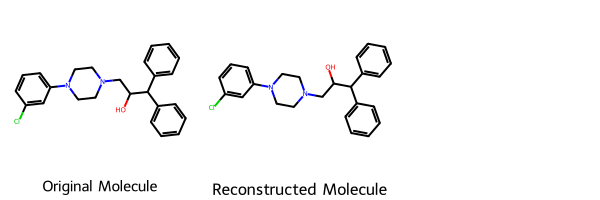

In [14]:
smiles_ = dd2_data_df.iloc[0]["largest_frag_smiles"]
graph = gnn_utils.graph_from_molecule(
    MolFromSmiles(smiles_),
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
)
print(f"graph = {graph}")
molecule = gnn_utils.graph_to_molecule(
    graph, atom_featurizer=atom_featurizer, bond_featurizer=bond_featurizer
)

print(
    [
        f"{bond.GetBeginAtomIdx()}-{bond.GetEndAtomIdx()} :: {bond.GetStereo()}"
        for bond in MolFromSmiles(smiles_).GetBonds()
    ]
)
# print(graph.edge_index.t().tolist())
print(
    [
        f"{bond.GetBeginAtomIdx()}-{bond.GetEndAtomIdx()} :: {bond.GetStereo()}"
        for bond in molecule.GetBonds()
    ]
)
Draw.MolsToGridImage(
    [MolFromSmiles(smiles_), molecule],
    legends=["Original Molecule", "Reconstructed Molecule"],
)

graph = Data(x=[14, 73], edge_index=[2, 42], edge_attr=[42, 24], global_feats=[1, 165])
['0-1 :: STEREONONE', '1-2 :: STEREOZ', '2-3 :: STEREONONE', '3-4 :: STEREOZ', '4-5 :: STEREONONE', '5-6 :: STEREONONE', '6-7 :: STEREONONE', '7-8 :: STEREONONE', '8-9 :: STEREONONE', '9-10 :: STEREONONE', '10-11 :: STEREONONE', '11-12 :: STEREONONE', '12-13 :: STEREONONE', '11-6 :: STEREONONE']
['0-1 :: STEREONONE', '1-2 :: STEREOZ', '2-3 :: STEREONONE', '3-4 :: STEREOZ', '4-5 :: STEREONONE', '5-6 :: STEREONONE', '6-7 :: STEREONONE', '6-11 :: STEREONONE', '7-8 :: STEREONONE', '8-9 :: STEREONONE', '9-10 :: STEREONONE', '10-11 :: STEREONONE', '11-12 :: STEREONONE', '12-13 :: STEREONONE']


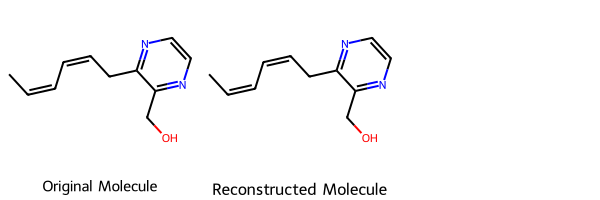

In [15]:
## Let's try a molecule with stereochemical information
# Remember that the ordering of bonds might differ slightly.
# Moreover, since the bon are undirected, the source and desination atoms
# indices might be permuted in some cases.
smiles_ = "C\C=C/C=C\Cc1nccnc1CO"
graph = gnn_utils.graph_from_molecule(
    MolFromSmiles(smiles_),
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
)
print(f"graph = {graph}")
molecule = gnn_utils.graph_to_molecule(
    graph, atom_featurizer=atom_featurizer, bond_featurizer=bond_featurizer
)

print(
    [
        f"{bond.GetBeginAtomIdx()}-{bond.GetEndAtomIdx()} :: {bond.GetStereo()}"
        for bond in MolFromSmiles(smiles_).GetBonds()
    ]
)

# print(graph.edge_index.t().tolist())
print(
    [
        f"{bond.GetBeginAtomIdx()}-{bond.GetEndAtomIdx()} :: {bond.GetStereo()}"
        for bond in molecule.GetBonds()
    ]
)
Draw.MolsToGridImage(
    [MolFromSmiles(smiles_), molecule],
    legends=["Original Molecule", "Reconstructed Molecule"],
)

<p style="font-family: cursive; font-size=16px">As you can see, The molecule was succesfully reconstructed and is identical to the original one.<p>

<h4 style="font-family: cursive"> Data splitting</h4>
<p style="font-family: cursive; font-size=16px">We will split the data into train, validation and test sets, using the scaffold splitting method. Small-molecule scaffold splitting, particularly using the Bemis-Murcko scaffold approach, involves identifying and extracting the core structural framework shared among a set of chemical compounds, excluding variable substituents. This process simplifies and abstracts the diverse chemical structures, aiding in the analysis of chemical libraries and structure-activity relationships. The Bemis-Murcko scaffold represents the most conserved structural elements of the compounds.<br/>While scaffold splitting facilitates the identification of key structural motifs,and can enhance model interpretation, it has limitations in handling highly flexible or structurally diverse molecules,and may result in the loss of detailed iformation about specific functional groups or substituents, potentially oversimplifying structure-activity relationships. Moreover, In some cases, scaffold splitting may lead to overly strict splitting criteria, resulting in training, validation, and test sets that are too similar in chemical space.</p>

In [16]:
molecules = dd2_data_df["largest_frag"].values
targets = dd2_data_df[target_column].values

splitter = splitters.ScaffoldSplitter()
train_idx, val_idx, test_idx = splitter.train_val_test_split(
    molecules=molecules,
    train_ratio=0.8,
    val_ratio=0.15,
    test_ratio=0.05,
    return_as_indices=True,
    return_as_clusters=False,
    include_chirality=False,
    sort_by_size=True,
    shuffle_idx=True,
    random_state=seed,
)

# csplitter = splitters.ClusterSplitter()
# train_idx, val_idx, test_idx = csplitter.train_val_test_split(molecules=molecules[:], train_ratio=0.8, val_ratio=0.1
#                             , test_ratio=0.1, return_as_indices=True, return_as_clusters=False, include_chirality=True
#                             , sort_by_size=True, shuffle_idx=False, random_state=seed, sim_cutoff=0.7)

# kfold_splits = splitter.kfold_split(molecules=molecules[:50], n_folds=3, return_as_indices=False, include_chirality=False
#                             , random_state=1)
# print(f"fold sizes: {[len(f) for f in kfold_splits]}")

train_mols, y_train = [molecules[i] for i in train_idx], targets[train_idx]
val_mols, y_val = [molecules[i] for i in val_idx], targets[val_idx]
test_mols, y_test = [molecules[i] for i in test_idx], targets[test_idx]

print(
    f"Dataset sizes: Train ({len(train_mols)}) - Validation ({len(val_mols)}) - Test ({len(test_mols)})"
)


smiles_and_labels = {}
largest_frag_smiles = dd2_data_df["largest_frag_smiles"].values
train_smiles = [largest_frag_smiles[i] for i in train_idx]
val_smiles = [largest_frag_smiles[i] for i in val_idx]
test_smiles = [largest_frag_smiles[i] for i in test_idx]

smiles_and_labels["train"] = (train_smiles, y_train)
smiles_and_labels["val"] = (val_smiles, y_val)
smiles_and_labels["test"] = (test_smiles, y_test)


pickle.dump(
    smiles_and_labels, open(f"{DATASET_DIR}/dd2_splits_smiles_and_labels.pkl", "wb")
)

Dataset sizes: Train (10816) - Validation (2028) - Test (676)


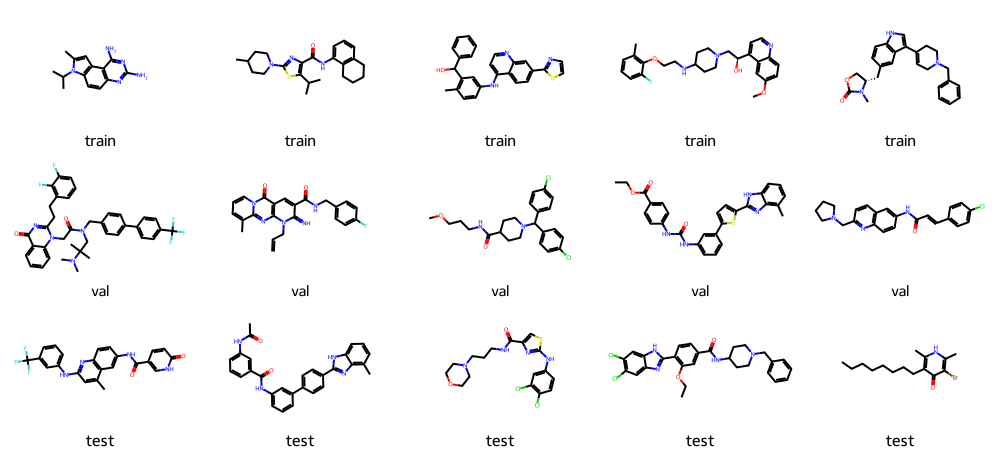

In [17]:
Draw.MolsToGridImage(
    sample(train_mols, 5) + sample(val_mols, 5) + sample(test_mols, 5),
    molsPerRow=5,
    subImgSize=(200, 150),
    legends=["train"] * 5 + ["val"] * 5 + ["test"] * 5,
    highlightAtomLists=None,
)

<h4 style="font-family: cursive">Featurization and Data Loading</h4>

In [18]:
%%time
# features_ = None

scale_features = True
feature_scaler = StandardScaler()


train_dataset = gnn_utils.get_dataset_from_mol_list(
    mol_list=train_mols[:],
    targets=y_train[:],
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_explicit_h=False,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=scale_features,
    feature_scaler=feature_scaler,
)

# # print(train_dataset[1].x, train_dataset[1].y, train_dataset[1].x[0].shape)
print(train_dataset[0])

Clean features...
global_feats_reshaped (10816, 165)
Data(x=[23, 73], edge_index=[2, 73], edge_attr=[73, 24], global_feats=[165], y=[1])
CPU times: user 8min 23s, sys: 1.9 s, total: 8min 24s
Wall time: 8min 24s


In [19]:
val_dataset = gnn_utils.get_dataset_from_mol_list(
    mol_list=val_mols,
    targets=y_val,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_explicit_h=False,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=scale_features,
    feature_scaler=feature_scaler,
)

test_dataset = gnn_utils.get_dataset_from_mol_list(
    mol_list=test_mols,
    targets=y_test,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_explicit_h=False,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=scale_features,
    feature_scaler=feature_scaler,
)

Clean features...
global_feats_reshaped (2028, 165)
Clean features...
global_feats_reshaped (676, 165)


In [20]:
dd2_dataset_fname = f"{DATASET_DIR}/dd2_datasets.pt"
torch.save(
    {
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
    },
    dd2_dataset_fname,
)

# train_dataset[0]

In [21]:
batch_size = 512
train_loader, val_loader, test_loader = datasets.get_dataloaders(
    train_data=train_dataset,
    test_data=test_dataset,
    val_data=val_dataset,
    batch_size=batch_size,
    shuffle_train=True,
    add_global_feats_to_nodes=True,
    num_workers=0,
)


# list(train_loader)[0].x[0].shape

dd2_loader_fname = f"{DATASET_DIR}/dd2_dataloaders.pt"

torch.save(
    {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
    },
    dd2_loader_fname,
)

dataset after adding global feat:  [Data(x=[23, 238], edge_index=[2, 73], edge_attr=[73, 24], y=[1]), Data(x=[22, 238], edge_index=[2, 70], edge_attr=[70, 24], y=[1]), Data(x=[26, 238], edge_index=[2, 82], edge_attr=[82, 24], y=[1]), Data(x=[26, 238], edge_index=[2, 82], edge_attr=[82, 24], y=[1]), Data(x=[20, 238], edge_index=[2, 64], edge_attr=[64, 24], y=[1]), Data(x=[21, 238], edge_index=[2, 67], edge_attr=[67, 24], y=[1]), Data(x=[21, 238], edge_index=[2, 67], edge_attr=[67, 24], y=[1]), Data(x=[23, 238], edge_index=[2, 73], edge_attr=[73, 24], y=[1]), Data(x=[21, 238], edge_index=[2, 67], edge_attr=[67, 24], y=[1]), Data(x=[21, 238], edge_index=[2, 67], edge_attr=[67, 24], y=[1]), Data(x=[25, 238], edge_index=[2, 79], edge_attr=[79, 24], y=[1]), Data(x=[23, 238], edge_index=[2, 73], edge_attr=[73, 24], y=[1]), Data(x=[25, 238], edge_index=[2, 79], edge_attr=[79, 24], y=[1]), Data(x=[23, 238], edge_index=[2, 73], edge_attr=[73, 24], y=[1]), Data(x=[24, 238], edge_index=[2, 76], ed

In [22]:
next(iter(train_loader))

DataBatch(x=[15992, 238], edge_index=[2, 50936], edge_attr=[50936, 24], y=[512], batch=[15992], ptr=[513])

<h3 style="font-family: cursive">Hyperparameter Tuning</h4>

In [23]:
in_channels = list(train_loader)[0].x[0].shape[0]

print(list(train_dataset[:2]))
print(list(train_loader)[0])
print(list(train_loader)[0].to_dict().keys())
# print(list(train_loader)[0].global_feats[0].__class__)
global_fdim = (
    None
    if list(train_loader)[0].to_dict().get("global_feats", None) is None
    else list(train_loader)[0].global_feats.shape[1]
)
print(global_fdim)

[Data(x=[23, 73], edge_index=[2, 73], edge_attr=[73, 24], global_feats=[165], y=[1]), Data(x=[22, 73], edge_index=[2, 70], edge_attr=[70, 24], global_feats=[165], y=[1])]
DataBatch(x=[16094, 238], edge_index=[2, 51342], edge_attr=[51342, 24], y=[512], batch=[16094], ptr=[513])
dict_keys(['x', 'edge_index', 'edge_attr', 'y', 'batch', 'ptr'])
None


In [24]:
# gcn_model = graph_nns.GCN(task='binary_classification', in_channels=in_channels, global_fdim=global_fdim, add_batch_norm=True)
# graph = next(iter(test_loader))
# print(graph)
# print(gcn_model(graph.x, graph.edge_index, graph.batch, graph.global_feats).detach().tolist())
# # torch.nn.Sigmoid()(gcn_model(graph.x, graph.edge_index, graph.batch, graph.global_feats))

In [25]:
%%time
import sklearn

criterion = torch.nn.BCEWithLogitsLoss()

# print(global_fdim)

exp_params_grid = {
    "task": "binary_classification",
    "in_channels": in_channels,
    "global_fdim": global_fdim,
    "model": ["graph_nns.GCN"],  # , 'graph_nns.GAT'
    # 'gnn_hidden_neurons': [128, 256, 384, 512]
    "gnn_hidden_neurons": [300, 600],
    "gnn_nlayers": [2, 3]
    # , 'ffn_hidden_neurons': [64, 128, 256, 384, 512]
    ,
    "ffn_hidden_neurons": [200, 400],
    "ffn_nlayers": [2, 3],
    "out_neurons": 1,
    "dropout_rate": [0.2, 0.4],
    "activation_func": ["torch.nn.LeakyReLU", "torch.nn.ReLU"],
    "gpooling_func": ["mean"]
    # , 'heads' : [3,4]
    # , 'edge_dim': bond_featurizer.dim
    # , 'add_edge_features': True
    # , 'learning_rate': [3e-2, 1.5e-1], 'n_epochs': [600,1000]
    ,
    "learning_rate": [2e-1, 4e-1],
    "n_epochs": [250, 400],
    "criterion": criterion,
    "optimizer": ["{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}"],
    "scheduler": [
        "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}"
    ]
    # , 'scheduler' : ["{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':75,  'mode':'triangular', 'cycle_momentum':True}"]
    ,
    "scoring_func": ["roc_auc_score"],
    "add_batch_norm": True,
}

my_hpo = training_utils.OptunaHPO(n_trials=4, n_jobs=1, sampler=None)

results = my_hpo.run_optimization(
    train_val_data=[train_loader, val_loader],
    params_grid=exp_params_grid,
    optuna_direction="maximize",
    split_mode="classic",
    study_name="my_gcn_study",
)

results

[I 2024-11-07 12:52:59,231] A new study created in memory with name: my_gcn_study


params = {'task': 'binary_classification', 'in_channels': 238, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 412, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 328, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.25070603635652966, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'learning_rate': 0.30376229514963554, 'n_epochs': 350, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.30376229514963554, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}
	lr_scheduler:  {'factor': 0.85, '

[I 2024-11-07 13:00:08,428] Trial 0 finished with value: 0.9043184753039936 and parameters: {'in_channels': 238, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 412, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 328, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.25070603635652966, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'learning_rate': 0.30376229514963554, 'n_epochs': 350, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.9043184753039936.



===> Epoch  350/350: Average Train Loss: 0.137 |  Average validation Loss: 0.463 | Validation Score: 0.904 | lr: 0.08277
params = {'task': 'binary_classification', 'in_channels': 238, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 428, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 312, 'ffn_nlayers': 3, 'out_neurons': 1, 'dropout_rate': 0.33801117450489315, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.27593112533741765, 'n_epochs': 400, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.27593112533741765, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'fo

[I 2024-11-07 13:08:34,853] Trial 1 finished with value: 0.8840776131517528 and parameters: {'in_channels': 238, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 428, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 312, 'ffn_nlayers': 3, 'out_neurons': 1, 'dropout_rate': 0.33801117450489315, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.27593112533741765, 'n_epochs': 400, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.9043184753039936.



===> Epoch  400/400: Average Train Loss: 0.109 |  Average validation Loss: 0.706 | Validation Score: 0.884 | lr: 0.04618
params = {'task': 'binary_classification', 'in_channels': 238, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 444, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 392, 'ffn_nlayers': 3, 'out_neurons': 1, 'dropout_rate': 0.3439184224506536, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'learning_rate': 0.2063710674862648, 'n_epochs': 400, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.2063710674862648, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, '

[I 2024-11-07 13:16:58,097] Trial 2 finished with value: 0.882783002668643 and parameters: {'in_channels': 238, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 444, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 392, 'ffn_nlayers': 3, 'out_neurons': 1, 'dropout_rate': 0.3439184224506536, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'learning_rate': 0.2063710674862648, 'n_epochs': 400, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.9043184753039936.



===> Epoch  400/400: Average Train Loss: 0.104 |  Average validation Loss: 0.787 | Validation Score: 0.883 | lr: 0.03453
params = {'task': 'binary_classification', 'in_channels': 238, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 540, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 296, 'ffn_nlayers': 3, 'out_neurons': 1, 'dropout_rate': 0.2533787283624519, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.28381499809115834, 'n_epochs': 300, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.28381499809115834, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'for

[I 2024-11-07 13:23:50,618] Trial 3 finished with value: 0.8677171978207258 and parameters: {'in_channels': 238, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 540, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 296, 'ffn_nlayers': 3, 'out_neurons': 1, 'dropout_rate': 0.2533787283624519, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.28381499809115834, 'n_epochs': 300, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.9043184753039936.



===> Epoch  300/300: Average Train Loss: 0.126 |  Average validation Loss: 0.727 | Validation Score: 0.868 | lr: 0.07734
CPU times: user 29min 46s, sys: 1min 2s, total: 30min 48s
Wall time: 30min 51s


{'best_params': {'in_channels': 238,
  'model': 'graph_nns.GCN',
  'gnn_hidden_neurons': 412,
  'gnn_nlayers': 2,
  'ffn_hidden_neurons': 328,
  'ffn_nlayers': 2,
  'out_neurons': 1,
  'dropout_rate': 0.25070603635652966,
  'activation_func': 'torch.nn.LeakyReLU',
  'gpooling_func': 'mean',
  'learning_rate': 0.30376229514963554,
  'n_epochs': 350,
  'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}",
  'scheduler': "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.85, 'patience':30, 'threshold':5e-02, 'eps':1e-08}",
  'scoring_func': 'roc_auc_score'},
 'best_score': 0.9043184753039936}

<h3 style="font-family: cursive">Training and Evaluating The Best Model</h3>

In [26]:
best_params = results["best_params"]
# best_params.update(**{'task':'binary_classification'})
# print("Best params: ", best_params)


# best_gnn_model = eval(best_params['model']).from_dict({
#     "task" : best_params['task']
#     , 'in_channels': best_params['in_channels'],  'gnn_hidden_neurons' : int(best_params['gnn_hidden_neurons'])
#     , 'gnn_nlayers' : best_params['gnn_nlayers'], 'global_fdim' : best_params.get('global_fdim', None)
#     , 'ffn_hidden_neurons' :int(best_params['ffn_hidden_neurons']), 'ffn_nlayers' : best_params['ffn_nlayers']
#     , 'out_neurons' : best_params['out_neurons'], 'dropout_rate' : best_params['dropout_rate']
#     , 'gpooling_func' : best_params['gpooling_func'], 'activation_func' : best_params['activation_func']
#     , 'add_batch_norm' : True
# })

<h4 style="font-family: cursive"> Model Training</h4>

In [27]:
# gnn_trainer = training_utils.GNNTrainer(task=best_params['task'], model=best_gnn_model
#                                             , scheduler=best_params['scheduler']
#                                             , optimizer=best_params['optimizer']
#                                             , criterion=criterion
#                                             , scoring_func=eval(best_params['scoring_func'])
#                                             , n_epochs=best_params['n_epochs']
#                                             , learning_rate=best_params['learning_rate']
#                                         )
# gnn_trainer.__dict__

In [28]:
# %%time
# train_losses, val_losses, val_scores = gnn_trainer.train(train_loader=train_loader, val_loader=val_loader)

In [29]:
%%time
best_gcn_model = my_hpo.best_model
train_losses, val_losses, val_scores = (
    my_hpo.train_val_metadata["train_losses"],
    my_hpo.train_val_metadata["val_losses"],
    my_hpo.train_val_metadata["val_scores"],
)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


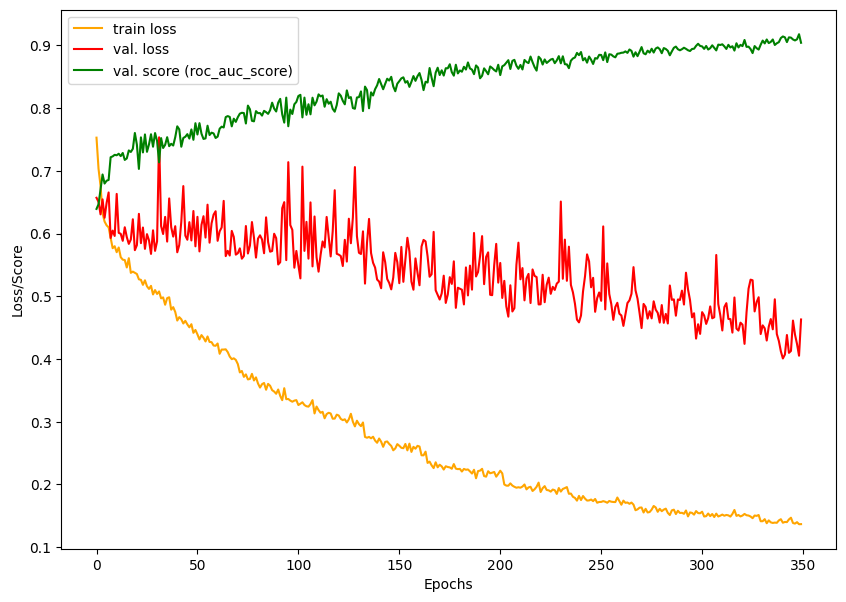

In [30]:
visuals.plots_train_val_metrics(
    train_losses=train_losses,
    val_scores=val_scores,
    val_losses=val_losses,
    figsize=(10, 7),
    image_pathname=f"{DATASET_DIR}/figures/dd2_class_best_gcn_stats.jpeg",
    val_score_name=best_params["scoring_func"],
)

In [31]:
torch.save(best_gcn_model, f"{DATASET_DIR}/models/dd2_class_best_gcn_model.pt")

<h4 style="font-family: cursive"> Model Evaluation</h4>

In [32]:
from lib import predictions

test_pred, test_true = predictions.predict_from_loader(
    loader=test_loader,
    model=best_gcn_model,
    device="cuda:0",
    return_class_as_proba=True,
    return_true_targets=True,
    desc="Predicting...",
)
print(test_pred.tolist())
threshold = 0.5
test_pred_classes = [int(x > threshold) for x in test_pred.squeeze(1)]

# print(test_pred)
print(test_pred_classes)

roc_auc = round(roc_auc_score(test_true.cpu(), test_pred.detach().cpu()), 3)
f1_ = round(f1_score(test_true.cpu(), test_pred_classes), 3)

print(f"\nROC AUC Score = {roc_auc}")
print(
    f"Balanced Acc.   = {round(balanced_accuracy_score(test_true.cpu(), test_pred_classes),3)}"
)
print(f"F1-Score        = {f1_}")
print(
    f"Precision       = {round(precision_score(test_true.cpu(), test_pred_classes),3)}"
)
print(f"Recall          = {round(recall_score(test_true.cpu(), test_pred_classes),3)}")

[[0.002814000006765127], [0.011769981123507023], [0.4162409007549286], [0.026584047824144363], [0.8514052629470825], [0.00029617699328809977], [0.9968112111091614], [0.01548871397972107], [0.004186346661299467], [0.007072553504258394], [0.0006983515340834856], [0.00023839322966523468], [0.00018246157560497522], [0.9999487400054932], [0.7046734690666199], [0.9702593088150024], [0.0024848615285009146], [0.934581458568573], [0.9994538426399231], [0.0011872900649905205], [0.9921200275421143], [0.9996500015258789], [0.9980613589286804], [0.9166128635406494], [0.7808247804641724], [0.9752911329269409], [0.08462908864021301], [0.00047302100574597716], [0.001790315960533917], [0.00520458584651351], [0.5355325937271118], [0.4149308204650879], [0.4191132187843323], [0.8883122801780701], [0.005529356189072132], [0.005522755440324545], [0.9483681917190552], [0.039040349423885345], [0.0006269113509915769], [0.00218608183786273], [0.639954686164856], [0.9957513809204102], [0.834297776222229], [0.061

<h5 style="font-family: cursive"> Evaluate using the GNNPredictor</h5>

In [38]:
# print(dir(atom_featurizer))
# print(atom_featurizer.features_mapping)
best_gcn_predictor = predictions.GNNPredictor(
    model=best_gcn_model,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    add_explicit_h=False,
    mol_featurizer=mol_featurizer,
    scale_features=True,
    feature_scaler=StandardScaler(),
    compute_global_features=True,
    add_global_feats_to_nodes=True,
)

In [39]:
best_gnn_model = torch.load(f"{DATASET_DIR}/models/dd2_class_best_gnn_model.pt")
# torch.save(best_gcn_predictor, f"{DATASET_DIR}/models/dd2_class_best_gcn_predictor.pt")

In [35]:
# best_gnn_predictor=torch.load(f"{DATASET_DIR}/models/dd2_class_best_gnn_predictor.pt")
# best_gnn_predictor

# dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders.pt'
# dd2_loaders = torch.load(dd2_loader_fname)

# train_loader = dd2_loaders['train_loader']
# val_loader   = dd2_loaders['val_loader']
# test_loader  = dd2_loaders['test_loader']

In [40]:
test_pred, test_true = best_gcn_predictor.predict_from_loader(
    loader=test_loader,
    return_class_as_proba=True,
    device="cuda:0",
    return_true_targets=True,
    desc="Predicting...",
)

# print(test_pred)
### Let's try a higher threshold

test_pred = test_pred.detach().cpu().squeeze(1).tolist()
print("test_pred        ", test_pred)
test_pred_classes = [int(x > threshold) for x in test_pred]
print("test_pred_classes", test_pred_classes)

test_true = test_true.cpu()

print(f"\nROC AUC Score = {round(roc_auc_score(test_true, test_pred),3)}")
print(
    f"Balanced Acc.   = {round(balanced_accuracy_score(test_true, test_pred_classes),3)}"
)
print(f"F1-Score        = {round(f1_score(test_true, test_pred_classes),3)}")
print(f"Precision       = {round(precision_score(test_true, test_pred_classes),3)}")
print(f"Recall          = {round(recall_score(test_true, test_pred_classes),3)}")

test_pred         [0.002814001403748989, 0.01176998671144247, 0.4162401258945465, 0.02658398635685444, 0.8514052629470825, 0.00029617699328809977, 0.9968112111091614, 0.015488699078559875, 0.0041863503865897655, 0.007072553504258394, 0.0006983515340834856, 0.00023839322966523468, 0.00018246157560497522, 0.9999487400054932, 0.7046735286712646, 0.9702593088150024, 0.0024848568718880415, 0.934581458568573, 0.9994538426399231, 0.0011872900649905205, 0.9921200275421143, 0.9996500015258789, 0.9980613589286804, 0.9166128635406494, 0.7808247804641724, 0.9752911329269409, 0.08462908864021301, 0.00047302187886089087, 0.001790315960533917, 0.00520458584651351, 0.535532534122467, 0.4149308204650879, 0.4191132187843323, 0.8883122801780701, 0.005529358517378569, 0.005522752646356821, 0.9483681917190552, 0.03904031217098236, 0.0006269113509915769, 0.0021860827691853046, 0.639954686164856, 0.9957513809204102, 0.834297776222229, 0.06161041557788849, 0.7274645566940308, 0.6594529151916504, 0.97125017642

In [41]:
### Here, we use the test_dataset instead of the loader, just to make sure the predictor
# works as expeted. We must get the same values as earlier.

test_pred_classes, test_true = best_gcn_predictor.predict_from_data_list(
    data=test_dataset,
    batch_size=batch_size,
    return_class_as_proba=False,
    device="cuda:0",
    return_true_targets=True,
    desc="Predicting...",
)
test_true = test_true.cpu().tolist()
test_pred_classes = test_pred_classes.cpu().tolist()
print("test_pred_classes", test_pred_classes)

# print(f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred),3)}")
print(
    f"Balanced Acc.   = {round(balanced_accuracy_score(test_true, test_pred_classes),3)}"
)
print(f"F1-Score        = {round(f1_score(test_true, test_pred_classes),3)}")
print(f"Precision       = {round(precision_score(test_true, test_pred_classes),3)}")
print(f"Recall          = {round(recall_score(test_true, test_pred_classes),3)}")


## Let's try a different threshold
threshold = 0.6
print(f"\n Threshold = {threshold}")

test_pred_classes, test_true = best_gcn_predictor.predict_from_data_list(
    data=test_dataset,
    batch_size=batch_size,
    return_class_as_proba=False,
    device="cuda:0",
    return_true_targets=True,
    desc="Predicting...",
    binary_threshold=threshold,
)

test_true = test_true.cpu().tolist()
test_pred_classes = test_pred_classes.cpu().tolist()
print("test_pred_classes", test_pred_classes)

# print(f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred),3)}")
print(
    f"Balanced Acc.   = {round(balanced_accuracy_score(test_true, test_pred_classes),3)}"
)
print(f"F1-Score        = {round(f1_score(test_true, test_pred_classes),3)}")
print(f"Precision       = {round(precision_score(test_true, test_pred_classes),3)}")
print(f"Recall          = {round(recall_score(test_true, test_pred_classes),3)}")

add_global_feats_to_nodes True
dataset after adding global feat:  [Data(x=[35, 238], edge_index=[2, 111], edge_attr=[111, 24], y=[1]), Data(x=[41, 238], edge_index=[2, 129], edge_attr=[129, 24], y=[1]), Data(x=[37, 238], edge_index=[2, 117], edge_attr=[117, 24], y=[1]), Data(x=[28, 238], edge_index=[2, 92], edge_attr=[92, 24], y=[1]), Data(x=[29, 238], edge_index=[2, 95], edge_attr=[95, 24], y=[1]), Data(x=[39, 238], edge_index=[2, 125], edge_attr=[125, 24], y=[1]), Data(x=[46, 238], edge_index=[2, 144], edge_attr=[144, 24], y=[1]), Data(x=[35, 238], edge_index=[2, 111], edge_attr=[111, 24], y=[1]), Data(x=[36, 238], edge_index=[2, 110], edge_attr=[110, 24], y=[1]), Data(x=[30, 238], edge_index=[2, 96], edge_attr=[96, 24], y=[1]), Data(x=[31, 238], edge_index=[2, 99], edge_attr=[99, 24], y=[1]), Data(x=[31, 238], edge_index=[2, 99], edge_attr=[99, 24], y=[1]), Data(x=[32, 238], edge_index=[2, 102], edge_attr=[102, 24], y=[1]), Data(x=[25, 238], edge_index=[2, 81], edge_attr=[81, 24], y

<h5 style="font-family: cursive"> Predict DD2 Activity from SMILES</h5>

In [42]:
smiles = ["CCC(=O)NCc1nccc1CO", "O=C(O)c1cccnc1Sc1cc(CCO)c(Cl)cc1"]

pred_classes = best_gcn_predictor.predict_from_smiles_list(
    smiles_list=smiles, device="cuda:0", desc="Predicting...", binary_threshold=0.5
)


print("pred_classes", pred_classes.cpu())

Clean features...
add_global_feats_to_nodes True
dataset after adding global feat:  [Data(x=[13, 238], edge_index=[2, 39], edge_attr=[39, 24]), Data(x=[20, 238], edge_index=[2, 62], edge_attr=[62, 24])]
loader:  DataBatch(x=[33, 238], edge_index=[2, 101], edge_attr=[101, 24], batch=[33], ptr=[3])
pred_classes tensor([1., 1.])


In [43]:
html_content = f'<p style="font-family: cursive">We have trained a {best_gcn_model.__class__.__name__} model for predicting the DD2 activity of small molecules. The model trained models achieved a ROC AUC score, and F1-score  of {roc_auc}, and {f1_}, respectively. Exploring a larger hyperpamareter space for tuning could help improving the performance</p>'
html_content += '<p style="font-family: cursive">It is very helfpul for model development and use to trust the predictions. There are tools that allow to explain graph-based models. These can be helfpful as they provide an intuitive visualization and interpretability of the predictions. We use PyTorch Geometric Explainer module, in combination with NetworkX. See how it is used in the <a href="./dd2_gnn_explanation.ipynb">dd2_gnn_explanation notebook</a>.</p>'

display(HTML(html_content))

<h5 style="font-family: cursive"> Predict DD2 Activity from SMILES (Without the GNN Predictor)</h5>

In [45]:
### Predict directly from smiles, without using the GNNPredictor Object
predictions.predict_from_smiles_list(
    best_gcn_model,
    smiles_list=smiles,
    batch_size=2,
    device="cuda:0",
    add_explicit_h=False,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_global_feats_to_nodes=True,
    shuffle=False,
    num_workers=0,
    desc="Predicting...",
).detach()

Clean features...
add_global_feats_to_nodes True
dataset after adding global feat:  [Data(x=[13, 238], edge_index=[2, 39], edge_attr=[39, 24]), Data(x=[20, 238], edge_index=[2, 62], edge_attr=[62, 24])]
loader:  DataBatch(x=[33, 238], edge_index=[2, 101], edge_attr=[101, 24], batch=[33], ptr=[3])


tensor([1., 1.], device='cuda:0')

In [46]:
### Predict directly from data list, without using the GNNPredictor Object
print(
    "Prediction from dataset : ",
    predictions.predict_from_data_list(
        best_gcn_model,
        data=test_dataset[:2],
        add_global_feats_to_nodes=True,
        batch_size=2,
        device="cuda:0",
        # add_explicit_h=False,
        # atom_featurizer=atom_featurizer,
        # bond_featurizer=bond_featurizer,
        # mol_featurizer=mol_featurizer,
        return_true_targets=False,
        shuffle=False,
        num_workers=0,
        desc="Predicting...",
    ).detach(),
)

### Predict directly from the loader, without using the GNNPredictor Object
print(
    "Prediction from loader : ",
    predictions.predict_from_loader(
        best_gcn_model,
        loader=test_loader,
        device="cuda:0",
        return_true_targets=True,
        desc="Predicting...",
    )[0]
    .detach()
    .tolist()[:25],
)

add_global_feats_to_nodes True
dataset after adding global feat:  [Data(x=[35, 238], edge_index=[2, 111], edge_attr=[111, 24], y=[1]), Data(x=[41, 238], edge_index=[2, 129], edge_attr=[129, 24], y=[1])]
loader:  DataBatch(x=[76, 238], edge_index=[2, 240], edge_attr=[240, 24], y=[2], batch=[76], ptr=[3])
Prediction from dataset :  tensor([0., 0.], device='cuda:0')
Prediction from loader :  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
